In [ ]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 30.1MB/s 
     |████████████████████████████████| 7.6MB 7.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from os.path import exists

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

7.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/kt_tumor_train.zip -d train
!unzip -q /content/gdrive/MyDrive/kt_tumor_val.zip -d val

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Jan 25 22:46:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
unlabeler = LabelEncoder()
labels = [path.parent.name for path in train_files]
unlabeler.fit(labels)
with open('label_tumor_smalla_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [ ]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = torch.FloatTensor([1 if path.parent.name=="опухоль" else 0 for path in self.files])
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
import random

In [ ]:
TRAIN_DIR = Path('train/kt_tumor_train')
train_files = list(TRAIN_DIR.rglob('*.jpg'))
random.shuffle(train_files)
print(train_files)

[PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_SOFJYANOV_N.I.\u200e_(72y)_-_18.10.2020_11_52_00_-_Head__1.0__J30s_0081.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_POROSHIN_A_I\u200e_(70y)_-_22.09.2020_22_21_32_-_Head__1.5__J30s_0104.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_RAYKOVSKIY_S.M\u200e_(39y)_-_22.10.2020_19_56_35_-_Head__1.0__J30s_0060.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_GRISCHNYKOV_V.C\u200e_(60y)_-_23.10.2020_21_53_20_-_Cerebrum__1.5__H31s_0044.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_TAUSHKANOVA_L.I.\u200e_(71y)_-_10.08.2020_9_48_14_-_STD_1.25mm_0033.jpg'), PosixPath('train/kt_tumor_train/опухоль/3D_MPR_-_KRYUKOV_V_G\u200e_(64y)_-_18.10.2020_20_05_29_-_Head__1.5__J30s_0128.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутствует/3D_MPR_-_GOVORKINA_L.A\u200e_(65y)_-_22.09.2020_13_12_22_-_soft_0146.jpg'), PosixPath('train/kt_tumor_train/опухоль отсутст

In [ ]:
VAL_DIR = Path('val/kt_tumor_val')
val_files=list(VAL_DIR.rglob('*.jpg'))
random.shuffle(val_files)
print(val_files)

[PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0007.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_MITYUKHLYAEV_B_I\u200e_(81y)_-_01.10.2020_12_28_36_-__Head_0.5_0073.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0001.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_BARYISHEV_M.T\u200e_(73y)_-_09.08.2020_9_17_27_-_soft_0009.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_KABIEVA_A\u200e_(81y)_-_02.10.2020_20_46_25_-__Head_0.5_0101.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_BISEROV_S_A\u200e_(71y)_-_19.10.2020_20_30_13_-_STD_5mm_0068.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_MITYUKHLYAEV_B_I\u200e_(81y)_-_01.10.2020_12_28_36_-__Head_0.5_0092.jpg'), PosixPath('val/kt_tumor_val/опухоль отсутствует/3D_MPR_-_BISEROV_S_A\u200e_(71y)_-_19.10.2020_20_30_13_-

In [ ]:
val_dataset = KTDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

351


In [ ]:
train_dataset = KTDataset(train_files, mode = 'train', encoder=unlabeler)

In [ ]:
print(len(train_files))

10067


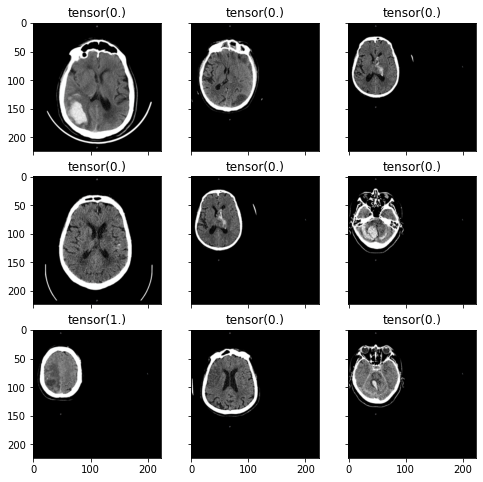

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
import torch.nn as nn

class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.out = nn.Linear(32, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # print(x.shape)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [ ]:
from torchvision import datasets, models, transforms

num_classes=1
torch.manual_seed(42)
np.random.seed(42)

base_model=SmallCnn(num_classes)

base_model=base_model.to(DEVICE)

# loss_fn = f1_loss

# optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        try:
            outputs=torch.reshape(outputs, (64,))
        except:
            outputs=torch.reshape(outputs, (19,))
        # print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # all_f1=0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            try:
                outputs=torch.reshape(outputs, (64,))
            except:
                outputs=torch.reshape(outputs, (31,))
            
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 0)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        # f1_metr=f1_score(labels.cpu(), preds.cpu(), average=None)
        # all_f1+=f1_metr
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # f1_result=all_f1/processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_binary_tumor_smalla_"+str(epoch+1)+".pth")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(base_model)

SmallCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.2895949234910479


epoch:   3%|▎         | 1/30 [04:10<2:01:14, 250.84s/it]


Epoch 001 train_loss: 0.2896     val_loss 0.4645 train_acc 0.0303 val_acc 0.2707
loss 0.17602929665645162


epoch:   7%|▋         | 2/30 [08:19<1:56:45, 250.19s/it]


Epoch 002 train_loss: 0.1760     val_loss 0.5132 train_acc 0.0247 val_acc 0.0000
loss 0.05426177570241645


epoch:  10%|█         | 3/30 [12:27<1:52:19, 249.60s/it]


Epoch 003 train_loss: 0.0543     val_loss 1.0304 train_acc 0.0071 val_acc 0.0000
loss 0.01768581668310292


epoch:  13%|█▎        | 4/30 [16:37<1:48:13, 249.75s/it]


Epoch 004 train_loss: 0.0177     val_loss 1.2111 train_acc 0.0034 val_acc 0.0000
loss 0.011590488640106922


epoch:  17%|█▋        | 5/30 [20:47<1:43:59, 249.60s/it]


Epoch 005 train_loss: 0.0116     val_loss 1.0916 train_acc 0.0127 val_acc 0.0000
loss 0.016692353796042347


epoch:  20%|██        | 6/30 [24:55<1:39:43, 249.33s/it]


Epoch 006 train_loss: 0.0167     val_loss 0.9797 train_acc 0.0356 val_acc 0.0000
loss 0.006721127862029901


epoch:  23%|██▎       | 7/30 [29:04<1:35:30, 249.14s/it]


Epoch 007 train_loss: 0.0067     val_loss 1.3114 train_acc 0.0070 val_acc 0.0000
loss 0.00250352695925032


epoch:  27%|██▋       | 8/30 [33:13<1:31:21, 249.14s/it]


Epoch 008 train_loss: 0.0025     val_loss 1.6077 train_acc 0.0344 val_acc 0.0000
loss 0.0027099738138487033


epoch:  30%|███       | 9/30 [37:23<1:27:19, 249.48s/it]


Epoch 009 train_loss: 0.0027     val_loss 1.6566 train_acc 0.0130 val_acc 0.0000
loss 0.0018524225725328814


epoch:  33%|███▎      | 10/30 [41:30<1:22:52, 248.61s/it]


Epoch 010 train_loss: 0.0019     val_loss 1.3455 train_acc 0.0200 val_acc 0.0000
loss 0.008281543422063182


epoch:  37%|███▋      | 11/30 [45:36<1:18:30, 247.94s/it]


Epoch 011 train_loss: 0.0083     val_loss 2.3323 train_acc 0.0088 val_acc 0.0000
loss 0.018318002795737844


epoch:  40%|████      | 12/30 [49:42<1:14:12, 247.35s/it]


Epoch 012 train_loss: 0.0183     val_loss 1.2451 train_acc 0.0181 val_acc 0.0000
loss 0.0008343563075583733


epoch:  43%|████▎     | 13/30 [53:49<1:10:02, 247.20s/it]


Epoch 013 train_loss: 0.0008     val_loss 1.2463 train_acc 0.0056 val_acc 0.0000
loss 0.001148476363238872


epoch:  47%|████▋     | 14/30 [57:58<1:06:02, 247.63s/it]


Epoch 014 train_loss: 0.0011     val_loss 1.2932 train_acc 0.0013 val_acc 0.0000
loss 0.0008971186741821111


epoch:  50%|█████     | 15/30 [1:02:07<1:02:02, 248.20s/it]


Epoch 015 train_loss: 0.0009     val_loss 1.4845 train_acc 0.0010 val_acc 0.0000
loss 0.0011517086182790343


epoch:  53%|█████▎    | 16/30 [1:06:16<57:58, 248.48s/it]


Epoch 016 train_loss: 0.0012     val_loss 1.2639 train_acc 0.0180 val_acc 0.0000
loss 0.0010834878993395383


epoch:  57%|█████▋    | 17/30 [1:10:25<53:49, 248.39s/it]


Epoch 017 train_loss: 0.0011     val_loss 1.3630 train_acc 0.0188 val_acc 0.0000
loss 0.001022098230911045


epoch:  60%|██████    | 18/30 [1:14:34<49:43, 248.63s/it]


Epoch 018 train_loss: 0.0010     val_loss 1.7824 train_acc 0.0072 val_acc 0.0000
loss 0.001965434308761579


epoch:  63%|██████▎   | 19/30 [1:18:44<45:38, 248.97s/it]


Epoch 019 train_loss: 0.0020     val_loss 1.4072 train_acc 0.0023 val_acc 0.0000
loss 0.0015764196971606022


epoch:  67%|██████▋   | 20/30 [1:22:53<41:29, 248.95s/it]


Epoch 020 train_loss: 0.0016     val_loss 1.5533 train_acc 0.0142 val_acc 0.0000
loss 0.053125485604787304


epoch:  70%|███████   | 21/30 [1:27:00<37:17, 248.60s/it]


Epoch 021 train_loss: 0.0531     val_loss 0.6547 train_acc 0.0176 val_acc 0.0000
loss 0.004584885479602186


epoch:  73%|███████▎  | 22/30 [1:31:08<33:07, 248.40s/it]


Epoch 022 train_loss: 0.0046     val_loss 0.8924 train_acc 0.0000 val_acc 0.0000
loss 0.0008699856108977607


epoch:  77%|███████▋  | 23/30 [1:35:16<28:58, 248.34s/it]


Epoch 023 train_loss: 0.0009     val_loss 0.8844 train_acc 0.0032 val_acc 0.0000
loss 0.0005470847572481747


epoch:  80%|████████  | 24/30 [1:39:24<24:47, 247.99s/it]


Epoch 024 train_loss: 0.0005     val_loss 0.8434 train_acc 0.0190 val_acc 0.0000
loss 0.0010017673922275724


epoch:  83%|████████▎ | 25/30 [1:43:29<20:35, 247.14s/it]


Epoch 025 train_loss: 0.0010     val_loss 1.1505 train_acc 0.0265 val_acc 0.0000
loss 0.0009290573137181735


epoch:  87%|████████▋ | 26/30 [1:47:33<16:24, 246.24s/it]


Epoch 026 train_loss: 0.0009     val_loss 1.0607 train_acc 0.0232 val_acc 0.0000
loss 0.0010610718126172443


epoch:  90%|█████████ | 27/30 [1:51:37<12:16, 245.50s/it]


Epoch 027 train_loss: 0.0011     val_loss 1.1807 train_acc 0.0192 val_acc 0.0000
loss 0.0019375603859424929


epoch:  93%|█████████▎| 28/30 [1:55:40<08:09, 244.92s/it]


Epoch 028 train_loss: 0.0019     val_loss 1.2866 train_acc 0.0179 val_acc 0.0000
loss 0.001609430241117877


epoch:  97%|█████████▋| 29/30 [1:59:45<04:04, 244.81s/it]


Epoch 029 train_loss: 0.0016     val_loss 1.2470 train_acc 0.0061 val_acc 0.0883
loss 0.0017735792820945018


epoch: 100%|██████████| 30/30 [2:03:49<00:00, 247.64s/it]


Epoch 030 train_loss: 0.0018     val_loss 1.4919 train_acc 0.0136 val_acc 0.0883


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

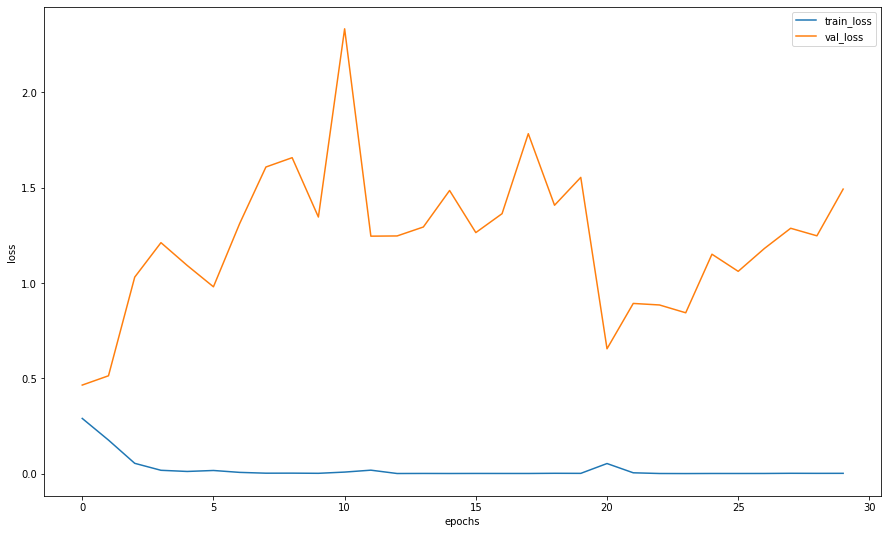

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    print(logits)
    probs = nn.functional.sigmoid(torch.cat(logits)).numpy()
    probs = [1 if i>=0.5 else 0 for i in probs]
    return probs

idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)
print(probs_ims)

actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score

print(actual_labels)
print(probs_ims)
print(f1_score(actual_labels, probs_ims, average=None))

nice=0
for i in range(100):
    if actual_labels[i]==probs_ims[i]:
      nice+=1
print(nice)

[tensor([[-53.5117]]), tensor([[-24.8164]]), tensor([[-15.6845]]), tensor([[-18.5709]]), tensor([[-43.7980]]), tensor([[-43.7980]]), tensor([[-11.8797]]), tensor([[-3.6676]]), tensor([[-18.7322]]), tensor([[-20.4753]]), tensor([[-11.8540]]), tensor([[-21.1805]]), tensor([[-6.4773]]), tensor([[-56.7065]]), tensor([[-49.0160]]), tensor([[-49.0160]]), tensor([[-51.2048]]), tensor([[-18.0362]]), tensor([[-52.1696]]), tensor([[-49.9081]]), tensor([[-20.1481]]), tensor([[-11.9444]]), tensor([[-49.9081]]), tensor([[-54.1028]]), tensor([[-33.6466]]), tensor([[-3.5789]]), tensor([[-55.2211]]), tensor([[-43.3134]]), tensor([[-18.3380]]), tensor([[-11.4013]]), tensor([[-19.1841]]), tensor([[-49.9149]]), tensor([[-12.4721]]), tensor([[-24.2988]]), tensor([[-22.1519]]), tensor([[-5.8874]]), tensor([[-51.2048]]), tensor([[-16.9604]]), tensor([[-25.6562]]), tensor([[-51.6295]]), tensor([[-18.7654]]), tensor([[-41.5227]]), tensor([[-11.7173]]), tensor([[-24.0765]]), tensor([[-49.7327]]), tensor([[-29.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), ten

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,260))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

In [ ]:
# actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
torch.save(base_model.state_dict(), "gdrive/MyDrive/KT_binary_tumor_smalla_v2_last.pth")

In [ ]:
def predict_picture(file_name):
    TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

    test_files = list(TEST_DIR.rglob(file_name))

    test_dataset = KTDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(base_model, test_loader)
    print(probs)
    predicted_proba = np.max(probs)*100
    for i in range(len(probs[0])):
      print(probs[0][i]*100, label_encoder.classes_[i])
    y_pred = np.argmax(probs)
    predicted_label = label_encoder.classes_[y_pred]
    return predicted_label, predicted_proba

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(predict_picture("10.jpg"))

[[2.3849365e-05 7.8634754e-02 9.4841748e-02 3.5471048e-02 3.6185865e-09
  9.6606191e-06 1.3273510e-01 2.4622777e-03 3.6915779e-08 1.2144416e-04
  3.2435180e-04 4.2660564e-02 6.1262834e-01 8.6691303e-05]]
0.0023849364879424684 ВЖК
7.8634753823280334 ВМГ 1
9.484174847602844 ВМГ 2
3.5471048206090927 ВМГ_ВЖК
3.6185865415205853e-07 ВМГ_ВЖК_САК
0.0009660619070928078 ВМГ_ВЖК_ишем
13.273510336875916 ВМГ_ишемия
0.24622776545584202 САК
3.6915778878210403e-06 САК_ВЖК
0.01214441581396386 САК_ВМГ
0.03243518003728241 СД
4.266056418418884 ишемия
61.26283407211304 опухоль
0.008669130329508334 эд_сд
('опухоль', 61.26283407211304)


In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

val_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
print(val_files)

[PosixPath('/content/gdrive/MyDrive/kt_test_fold/2.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/3.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/1.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/4.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/5.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/6.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/7.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/8.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/9.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/10.jpg')]


In [ ]:
val_dataset = KTDataset(val_files, mode='val')

In [ ]:
print(len(val_dataset))

10


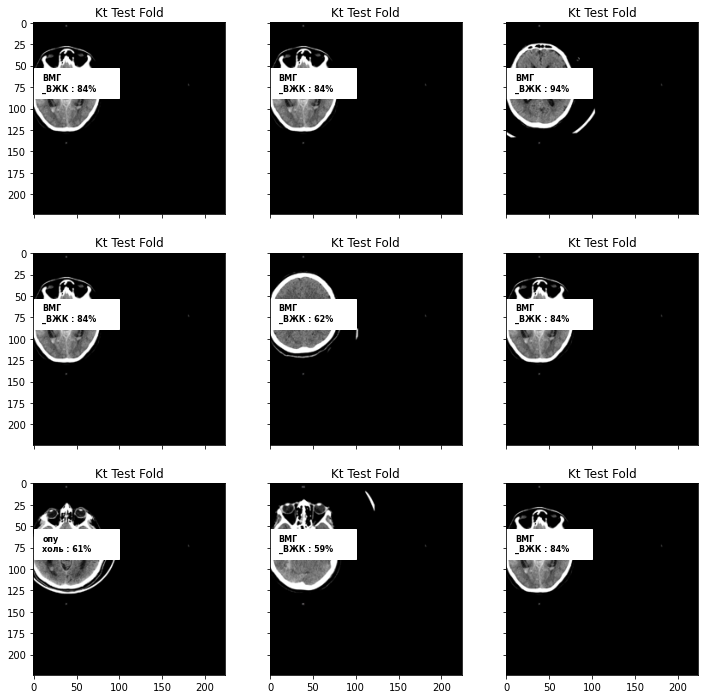

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

test_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
test_dataset = KTDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(base_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [ ]:
print(preds)

['ВМГ_ВЖК' 'опухоль' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ 2'
 'ишемия' 'ВМГ_ВЖК' 'ВМГ_ВЖК']


In [ ]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))